In [40]:
import os
import keras
import numpy as np
import tensorflow as tf
from keras.applications import vgg19
from time import sleep 
from IPython.display import Image, display

In [41]:
base_image_path = "/Users/andrii.p/Desktop/st-michaels-cathedral-kiev-ukraine-4450557.jpg"
style_reference_image_path = "/Users/andrii.p/Desktop/01TytulTradyttasuchpetrroz.jpg"
result_prefix = "KYIV_generated"

In [42]:
# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

In [43]:
# Dimensions of the generated picture.
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

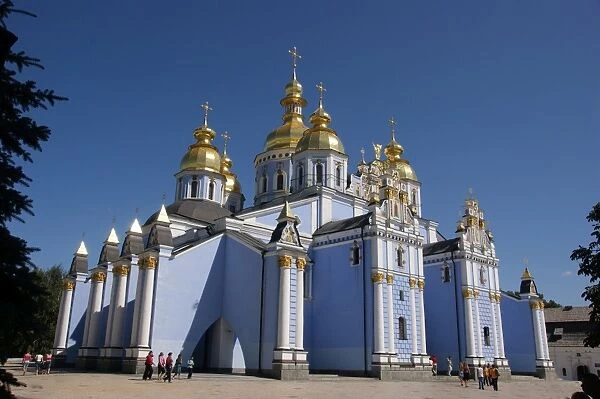

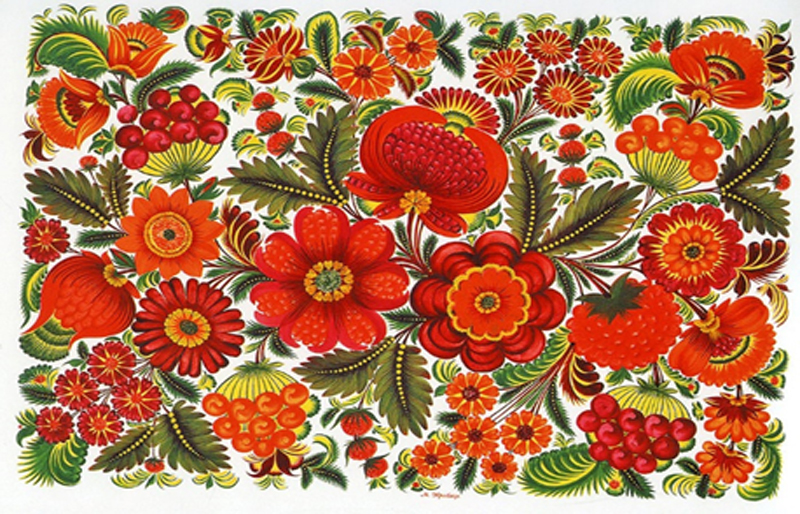

In [44]:
display(Image(base_image_path))
display(Image(style_reference_image_path))

In [45]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [46]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [47]:
model = vgg19.VGG19(weights="/Users/andrii.p/Downloads/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [48]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [49]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [34]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 40
for i in range(1, iterations + 1):
    print(i)
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0:
        print("10 sec pause")
        sleep(10)
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

1
2
3
4
5
6
7
8
9
10
10 sec pause
Iteration 10: loss=46770.77
11
12
13
14
15
16
17
18
19
20
10 sec pause
Iteration 20: loss=29002.56
21
22
23
24
25
26
27
28
29
30
10 sec pause
Iteration 30: loss=23800.31
31
32
33
34
35
36
37
38
39
40
10 sec pause
Iteration 40: loss=20936.61
